In [1]:
import os
import re
import glob
import nltk
import numpy as np
import pandas as pd
import pandas_access as mdb
import zipfile
import recordlinkage as rl
from os.path import join, basename
from meza import io
from params import get_params
from nltk.tokenize import word_tokenize
pd.set_option("display.max_columns", 150)

In [2]:
params = get_params()
path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/Dgis/Data/nacimiento/'
file = glob.glob(join(path,r'*.csv'))
file_zip = glob.glob(join(path,r'*.zip'))
nacimiento_2020 = 'nac_unzip/Nacimientos_cierre_2020/Nacimientos_cierre_2020.csv'

Access to database

In [3]:
## Access Birth 2020

#Select columns 
cols = ['FOLIO','NOMBRE','PRIMERAPELLIDO','SEGUNDOAPELLIDO','CURPMADRE',
'FECHANACIMIENTOMADRE','ENTIDADNACIMIENTO','ENTIDADNACIMIENTOD',
'MUNICIPIONACIMIENTO','MUNICIPIONACIMIENTOD',
'ENTIDADRESIDENCIA','ENTIDADRESIDENCIAD','MUNICIPIORESIDENCIA',
'MUNICIPIORESIDENCIAD','LOCALIDADRESIDENCIA','LOCALIDADRESIDENCIAD',
'HIJOSNACIDOSMUERTOS','HIJOSNACIDOSVIVOS','CERTIFICADODEFUNCION',
'AFILIACION','AFILIACIOND','FECHANACIMIENTO','HORANACIMIENTO','SEXO',
'ENTIDADFEDERATIVAPARTO','ENTIDADFEDERATIVAPARTOD','MUNICIPIOPARTO',
'MUNICIPIOPARTOD','LOCALIDADPARTO','LOCALIDADPARTOD','CODIGOPOSTALPARTO']

#Columns to rename
name = {'PRIMERAPELLIDO':'paterno',
'SEGUNDOAPELLIDO':'materno',
'CURPMADRE':'curp',
'FECHANACIMIENTOMADRE':'fech_nac_madre',
'ENTIDADNACIMIENTO':'ent_nac_madre',
'MUNICIPIONACIMIENTO':'mun_nac_madre',
'ENTIDADRESIDENCIA':'ent_res',
'MUNICIPIORESIDENCIA':'mun_res',
'LOCALIDADRESIDENCIA':'local_res',
'HIJOSNACIDOSMUERTOS':'hijos_muertos',
'HIJOSNACIDOSVIVOS':'hijos_vivos',
'FECHANACIMIENTO':'fech_nac',
'ENTIDADFEDERATIVAPARTO':'ent_parto',
'MUNICIPIOPARTO':'mun_parto',
'LOCALIDADPARTO':'localidad_parto'}

#Read data
nac2020 = pd.read_csv(join(path,nacimiento_2020), usecols= cols, low_memory=False)

#Rename columns
nac2020.rename(columns=name, inplace =True)

#To lower case columns
nac2020.columns = [x.lower() for x in nac2020.columns]


#To lower strings columns
nac2020 = nac2020.apply(lambda x: x.astype(str).str.lower())

#Convert to string
nac2020 = nac2020.convert_dtypes()

#Create fullname: Nombre + Apellido materno y paterno
nac2020['name'] = nac2020[['nombre', 'paterno', 'materno']].agg(' '.join, axis=1)

#Entity cleansing

In [ ]:
#Selección de los registros a corregir
RE_SUSPICIOUS = re.compile(r'desconocido|se ignora|sin informacion|[&#<>{}\[\]\\]')

def impurity(text, min_len=3):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# add new column to data frame
nac2020['impurity_before'] = nac2020['name'].apply(impurity, min_len=3)

# get the top 3 records
nac2020[['name', 'impurity_before']].sort_values(by='impurity_before', ascending=False)

In [5]:
len(nac2020[nac2020.impurity_before>0])

2306

In [6]:
def clean(text):
    # convert html escapes like &amp; to characters.
    #text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', '', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', '', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # Unnecessary words and characters
    text = re.sub(r'desconocido|se ignora|sin informacion|informacion|[&#<>{}\[\]\\]','', text)
    return text

nac2020['clean_name'] = nac2020['name'].map(clean)
#nac2020['impurity'] = nac2020['clean_name'].apply(impurity, min_len=3)
#nac2020[['clean_name', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
nac2020[nac2020['clean_name'].apply(impurity, min_len=3) > 0]

,folio,curp,nombre,paterno,materno,fech_nac_madre,ent_nac_madre,entidadnacimientod,mun_nac_madre,municipionacimientod,ent_res,entidadresidenciad,mun_res,municipioresidenciad,local_res,localidadresidenciad,hijos_muertos,hijos_vivos,certificadodefuncion,afiliacion,afiliaciond,fech_nac,horanacimiento,sexo,ent_parto,entidadfederativapartod,mun_parto,municipiopartod,localidad_parto,localidadpartod,codigopostalparto,name,impurity_before,clean_name


In [7]:
from collections import Counter

counter = Counter()

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter 
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data 
    counter = Counter() 
    
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq') 
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

count_words(nac2020, column='clean_name', preprocess=lambda t: re.findall(r'desconocido|se ignora|sin informacion|[?&#<>{}\[\]\\]*', t))

,freq
token,
,47357809


In [8]:
nac2020[['clean_name','name','nombre','paterno','materno']].isnull().sum()

clean_name    0
name          0
nombre        0
paterno       0
materno       0
dtype: int64

In [9]:
(nac2020[['name','clean_name']].nunique())

name          1657455
clean_name    1657002
dtype: int64

In [10]:
(nac2020[['name','clean_name']].nunique()/len(nac2020))

name          0.948284
clean_name    0.948025
dtype: float64

<AxesSubplot: >

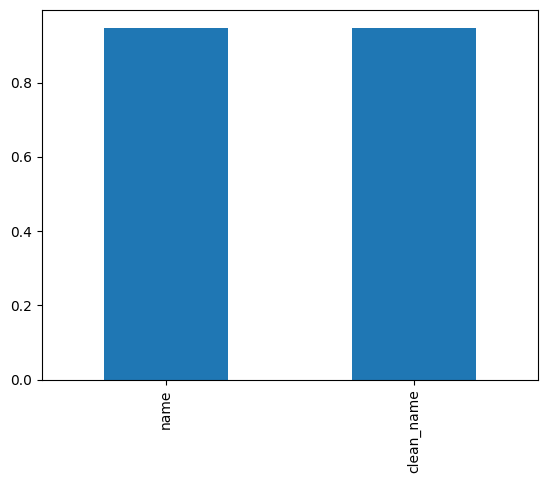

In [11]:
(nac2020[['name','clean_name']].nunique()/len(nac2020)).plot(kind='bar')

In [12]:
from recordlinkage.standardise import phonetic


class soundex():
    def soundex_met(nac202):
        return nac2020.assign(nombre_soundex=phonetic(nac2020['clean_name'],
                                                 method='soundex'))

    def result(nac2020):
        return nac2020.assign(
            id_soundex=nac2020[['nombre_soundex']].agg(''.join, axis=1))
        return id_soundex


nac2020 = soundex.soundex_met(nac2020)
nac2020 = soundex.result(nac2020)

In [13]:
from recordlinkage.index import Block
block_id_soundex = Block(on=['nombre_soundex'])
#block_id_s = block_id_soundex.index(nac2020)
#print(f"No of pairs: {len(block_id_s)}")

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_15455/306662049.py:2: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  block_id_soundex = Block(on=['nombre_soundex'])


In [14]:
import time

start_time = time.time()

#Blocking for CANDIDATE PAIRS
Block_name = Block(on=['nombre_soundex'])
Block_id = Block(on=['name', 'fech_nac_madre', 'ent_nac_madre'])

#Block_name_pairs = Block_name.index(nac2020)
#Block_id_pairs = Block_id.index(nac2020)

#pairs = Block_name_pairs.union(Block_id_pairs)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0001468658447265625 seconds ---


/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_15455/1082760955.py:6: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  Block_name = Block(on=['nombre_soundex'])
/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_15455/1082760955.py:7: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  Block_id = Block(on=['name', 'fech_nac_madre', 'ent_nac_madre'])
